In [117]:
#@title Setup & Imports
import os
import zipfile
import pandas as pd
from src.MAE.MAE_dataset import MAEDataset
from src.MAE.MAE_model import MaskedAutoencoderCNN
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt


from PIL import Image
import json
# import nltk
# from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
# from nltk.translate.meteor_score import meteor_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
import io
import random
from src.config import *
from src.dataset import load_csv_paths, create_dataloaders
from src.utils import build_vocab
from src.model import GRNN
from src.train import train_model, plot_history
from src.eval import test_loss, generate_question
from src.dataset import VQGTensorDataset
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [28]:
# import nltk
# import os

# nltk.download('punkt', download_dir='~/nltk_data')
# nltk.data.path.append(os.path.expanduser('~/nltk_data'))


In [107]:
import pandas as pd

def expand_questions(csv_path):
    df = pd.read_csv(csv_path)
    expanded_rows = []
    for _, row in df.iterrows():
        questions = str(row["questions"]).split('---')
        for q in questions:
            q = q.strip()
            if q:
                expanded_rows.append({
                    "image_id": row["image_id"],
                    "tensor_path": row["tensor_path"],
                    "questions": q  # single question per row
                })
    return pd.DataFrame(expanded_rows)


In [108]:
# Direct paths to CSVs
train_csv = "data/bing_data/bing_redistributed_indexes/bing_train_tensor_index.csv"
val_csv   = "data/bing_data/bing_redistributed_indexes/bing_val_tensor_index.csv"
test_csv  = "data/bing_data/bing_redistributed_indexes/bing_test_tensor_index.csv"

train_df = expand_questions(train_csv)
val_df = expand_questions(val_csv)
test_df = expand_questions(test_csv)


# Read all questions from all splits
# questions = []
# for path in [train_csv, val_csv, test_csv]:
#     df = pd.read_csv(path)
#     questions.extend(df["questions"].dropna().tolist())


In [109]:
train_exp_csv = "data/bing_data/bing_train_expanded.csv"
val_exp_csv   = "data/bing_data/bing_val_expanded.csv"
test_exp_csv  = "data/bing_data/bing_test_expanded.csv"

train_df.to_csv(train_exp_csv, index=False)
val_df.to_csv(val_exp_csv, index=False)
test_df.to_csv(test_exp_csv, index=False)

In [110]:
# Collect all questions for vocab
questions = pd.concat([train_df, val_df, test_df])["questions"].dropna().tolist()
vocab, idx_to_word = build_vocab(questions)

# Datasets with base_dir for .pt files
BASE_DIR = "data/bing_data"
train_dataset = VQGTensorDataset(train_exp_csv, vocab, MAX_LENGTH, base_dir=BASE_DIR)
val_dataset   = VQGTensorDataset(val_exp_csv, vocab, MAX_LENGTH, base_dir=BASE_DIR)
test_dataset  = VQGTensorDataset(test_exp_csv, vocab, MAX_LENGTH, base_dir=BASE_DIR)

# Dataloaders
from torch.utils.data import DataLoader
dataloaders = {
    "bing": {
        "train": DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
        "val":   DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False),
        "test":  DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False),
    }
}


In [71]:
model = GRNN(EMBED_SIZE, HIDDEN_SIZE, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)



Epoch 25: 100%|██████████| 119/119 [00:32<00:00,  3.66it/s]


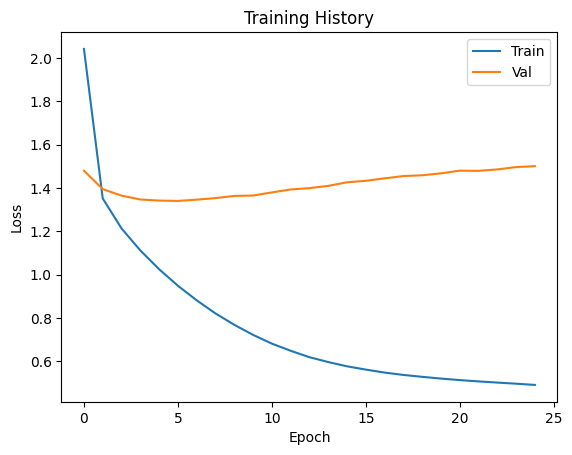

📉 Test Loss: 1.4853


In [72]:
history = train_model(model, dataloaders["bing"]["train"], dataloaders["bing"]["val"],
                      vocab, criterion, optimizer, device, 25)
plot_history(history)
test_loss(model, dataloaders["bing"]["test"], vocab, criterion, device)


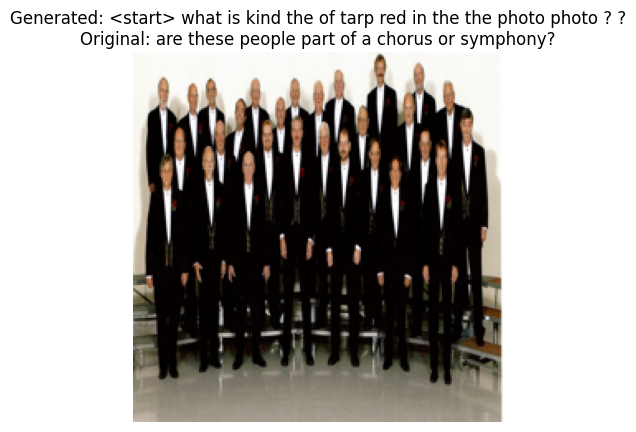

In [100]:
generate_question(model, dataloaders["bing"]["test"], vocab, idx_to_word, device)

In [ ]:
#next steps: 1) Data Agument (labels) dataset -> retrain 2) SSL + Pretrain for Image and maybe decoder

In [113]:
csvs = [
    "data/bing_data/bing_redistributed_indexes/bing_train_tensor_index.csv",
    "data/bing_data/bing_redistributed_indexes/bing_val_tensor_index.csv",
    "data/bing_data/bing_redistributed_indexes/bing_test_tensor_index.csv"
]


all_paths = []
for csv in csvs:
    df = pd.read_csv(csv)
    all_paths += [os.path.join("data/bing_data", p) for p in df["tensor_path"].dropna().tolist()]

print(f"✅ Loaded {len(all_paths)} image paths")


✅ Loaded 1922 image paths


In [114]:
PATCH_SIZE = 16
MASK_RATIO = 0.75
BATCH_SIZE = 64

mae_dataset = MAEDataset(all_paths, patch_size=PATCH_SIZE, mask_ratio=MASK_RATIO)
mae_loader = DataLoader(mae_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [115]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EMBED_DIM = 256

model = MaskedAutoencoderCNN(embed_dim=EMBED_DIM, patch_size=PATCH_SIZE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
EPOCHS = 15
history = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for masked, target, mask in tqdm(mae_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        masked, target, mask = masked.to(DEVICE), target.to(DEVICE), mask.to(DEVICE)

        out = model(masked, mask)  # [B, N, 3, p, p]
        loss = F.mse_loss(out[mask], target[mask])  # only masked patches

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(mae_loader)
    history.append(avg_loss)
    print(f"📉 Epoch {epoch+1}: avg loss = {avg_loss:.4f}")

torch.save(model.encoder.state_dict(), "pretrained_encoder.pth")
print("✅ Saved encoder weights to pretrained_encoder.pth")


Epoch 1/15: 100%|██████████| 31/31 [01:12<00:00,  2.35s/it]


📉 Epoch 1: avg loss = 0.1212


Epoch 2/15: 100%|██████████| 31/31 [01:18<00:00,  2.52s/it]


📉 Epoch 2: avg loss = 0.0888


Epoch 3/15:  13%|█▎        | 4/31 [00:10<01:09,  2.56s/it]

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history, label="MAE Train Loss", marker='o')
plt.title("Masked Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss (masked patches)")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import random

def show_mae_reconstruction(model, dataset, idx=None):
    model.eval()
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)

    masked, target, mask = dataset[idx]
    masked = masked.unsqueeze(0).to(DEVICE)
    mask = mask.unsqueeze(0).to(DEVICE)
    target = target.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        out = model(masked, mask)

    recon_img = out[0]
    true_img = target[0]
    masked_img = masked[0]

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    def reconstruct_image(patches):
        grid = torch.zeros(3, 224, 224)
        n = 0
        for i in range(0, 224, PATCH_SIZE):
            for j in range(0, 224, PATCH_SIZE):
                grid[:, i:i+PATCH_SIZE, j:j+PATCH_SIZE] = patches[n]
                n += 1
        return grid.clamp(0, 1)

    axs[0].imshow(reconstruct_image(true_img).permute(1, 2, 0).cpu())
    axs[0].set_title("Original Image")

    axs[1].imshow(reconstruct_image(masked_img).permute(1, 2, 0).cpu())
    axs[1].set_title("Masked Input")

    axs[2].imshow(reconstruct_image(recon_img).permute(1, 2, 0).cpu())
    axs[2].set_title("Reconstruction")

    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


In [ ]:
# Example usage
show_mae_reconstruction(model, mae_dataset)